In [2]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Signal generation

In [3]:
a = 0.9
b = 1.1
c = 0.1*pi
d = 0.01
f(x) = a .* sin.(b.*x .+ c) .+ d
df(x) = diagm(a .* b .* cos.(b.*x .+ c))
Q(q2) = 10^(q2/10)*diagm(ones(2))
R(r2) = 10^(r2/10)*diagm(ones(2))
H = [1 0; 0 1];
T = 100

100

In [4]:
function generate_signal(T, r2, q2)
    x_true = zeros(T, 2)
    y_true = zeros(T, 2)
    y_true[1,:] = rand(MvNormal(H*x_true[1,:], R(r2)))
    for k in 2:T
        x_true[k,:] = rand(MvNormal(f(x_true[k-1,:]), Q(q2)))
        y_true[k,:] = rand(MvNormal(H*x_true[k,:], R(r2)))
    end
    return y_true, x_true
end;

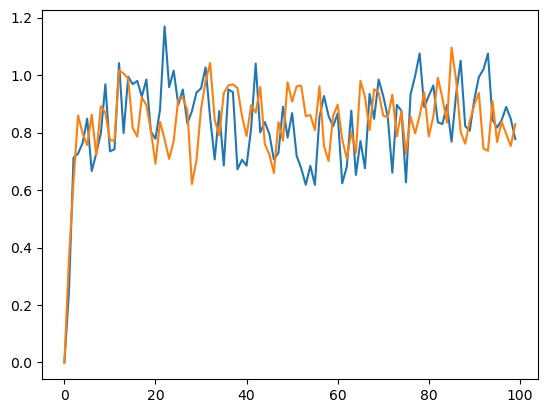

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A204B1C0>

In [5]:
y, x = generate_signal(T, 0, -20)

plt.plot(x[:,1])
plt.plot(x[:,2])

In [6]:
function EKF(signal, f, df, H, Q, R)

    # memory
    mem_x_m = Vector{Vector{Float64}}(undef, size(y,1))
    mem_x_v = Vector{Matrix{Float64}}(undef, size(y,1))

    # priors
    m_x = zeros(2)
    V_x = diagm(ones(2))

    for k in 1:size(y,1)
        
        # predict step
        m_x_new = f(m_x)
        J = df(m_x)
        V_x_new = J*V_x*J' + Q

        # update step
        y = signal[k,:] - H*m_x_new
        S = H*V_x_new*H' + R
        K = V_x_new * H' * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H)*V_x_new

        # save values
        mem_x_m[k] = copy(m_x)
        mem_x_v[k] = copy(V_x)

    end

    return mem_x_m, mem_x_v

end

EKF (generic function with 1 method)

In [19]:
function UKF(signal, f, df, H, Q, R)

    # settings 
    L = 2
    α = 1e-3
    κ = 0
    β = 2
    λ = α^2*(L+κ) - L
    Wm = ones(2*L + 1)
    Wc = ones(2*L + 1)
    Wm ./= (2*(L+λ))
    Wc ./= (2*(L+λ))
    Wm[1] = λ/(L+λ)
    Wc[1] = λ/(L+λ) + (1 - α^2 + β)

    # memory
    mem_x_m = Vector{Vector{Float64}}(undef, size(y,1))
    mem_x_v = Vector{Matrix{Float64}}(undef, size(y,1))

    # priors
    m_x = zeros(2)
    V_x = diagm(ones(2))

    for k in 1:size(y,1)

        # unscented
        sqrtΣ = cholsqrt((L + λ)*V_x)
        χ = Vector{Vector{Float64}}(undef, 2*L + 1)
        for ki = 1:length(χ)
            χ[ki] = copy(m_x)
        end
        for l = 2:L+1
            χ[l]     .+= real(sqrtΣ[l-1,:])
            χ[L + l] .-= real(sqrtΣ[l-1,:])
        end

        # transform sigma points
        Y = [f(χi) for χi in χ]

        # calculate new parameters
        μ_out = zeros(L)
        Σ_out = zeros(L, L)
        for ki = 1:2*L+1
            μ_out .+= Wm[ki] .* Y[ki]
        end
        for ki = 1:2*L+1
            Σ_out .+= Wc[ki] .* ( Y[ki] - μ_out ) *  ( Y[ki] - μ_out )'
        end

        m_x_new = μ_out
        V_x_new = Σ_out + Q

        # update step
        y = signal[k,:] - H*m_x_new
        S = H*V_x_new*H' + R
        K = V_x_new * H' * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H)*V_x_new

        # save values
        mem_x_m[k] = copy(m_x)
        mem_x_v[k] = copy(V_x)

    end

    return mem_x_m, mem_x_v

end

UKF (generic function with 1 method)

In [66]:
function PF(signal, f, df, H, Q, R)

    # settings 
    nr_samples = 1000

    # memory
    mem_x_m = Vector{Vector{Float64}}(undef, size(y,1))
    mem_x_v = Vector{Matrix{Float64}}(undef, size(y,1))

    # priors
    m_x = zeros(2)
    V_x = diagm(ones(2))

    for k in 1:size(y,1)

        X = rand(MvNormal(m_x, collect(Hermitian(V_x))), nr_samples)

        Y = [f(X[:,k]) for k in 1:nr_samples]

        m_x_new = mean(Y)
        V_x_new = cov(Y) + Q

        # update step
        y = signal[k,:] - H*m_x_new
        S = H*V_x_new*H' + R
        K = V_x_new * H' * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H)*V_x_new

        # save values
        mem_x_m[k] = copy(m_x)
        mem_x_v[k] = copy(V_x)

    end

    return mem_x_m, mem_x_v

end

PF (generic function with 1 method)

In [87]:
function XF(signal, f, df, H, Q, R)

    # settings 
    nr_samples = 10000

    # memory
    mem_x_m = Vector{Vector{Float64}}(undef, size(y,1))
    mem_x_v = Vector{Matrix{Float64}}(undef, size(y,1))

    # priors
    m_x = zeros(2)
    V_x = diagm(ones(2))

    for k in 1:size(y,1)

        X = rand(MvNormal(m_x, collect(Hermitian(V_x))), nr_samples)

        Y = [f(X[:,k]) for k in 1:nr_samples]

        Z = [Y[k] + rand(MvNormal(zeros(2), collect(Hermitian(Q)))) for k in 1:nr_samples]

        # upward message
        xi_up = H'*signal[k,:]
        w_up = H'* R * H
        v_up = cholinv(w_up)
        m_up = v_up * xi_up

        w = [pdf(MvNormal(m_up, v_up), z) for z in Z]

        m_x = sum([w[k] * Z[k] for k in 1:nr_samples])/sum(w)
        V_x = sum([w[k] * (Z[k] - m_x) * (Z[k] - m_x)' for k in 1:nr_samples])/sum(w)

        # save values
        mem_x_m[k] = copy(m_x)
        mem_x_v[k] = copy(V_x)

    end

    return mem_x_m, mem_x_v

end

XF (generic function with 1 method)

In [104]:
m_ekf, V_ekf = EKF(y, f, df, H, Q(0), R(0))
mx_ekf = hcat(m_ekf...)
Vx_ekf = hcat([[vi[1,1], vi[2,2]] for vi in V_ekf]...);

In [105]:
m_ukf, V_ukf = UKF(y, f, df, H, Q(0), R(0))
mx_ukf = hcat(m_ukf...)
Vx_ukf = hcat([[vi[1,1], vi[2,2]] for vi in V_ukf]...);

In [106]:
m_pf, V_pf = PF(y, f, df, H, Q(0), R(0))
mx_pf = hcat(m_pf...)
Vx_pf = hcat([[vi[1,1], vi[2,2]] for vi in V_pf]...);

In [107]:
m_xf, V_xf = XF(y, f, df, H, Q(0), R(0))
mx_xf = hcat(m_xf...)
Vx_xf = hcat([[vi[1,1], vi[2,2]] for vi in V_xf]...);

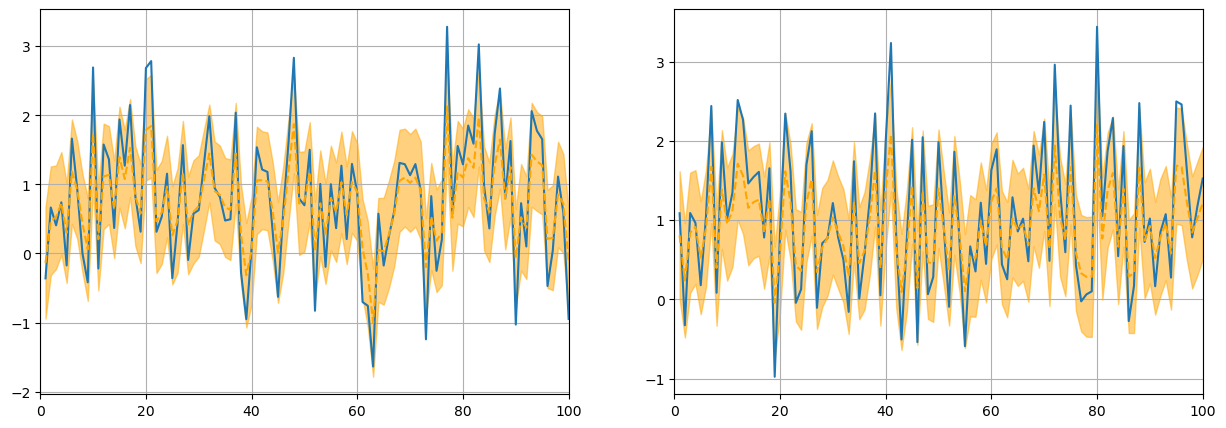

In [108]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(1:T, y[:,1])
ax[2].plot(1:T, y[:,2])
ax[1].fill_between(1:T, mx_ekf[1,:] .+ sqrt.(Vx_ekf[1,:]), mx_ekf[1,:] .- sqrt.(Vx_ekf[1,:]), color="orange", alpha=0.5)
ax[2].fill_between(1:T, mx_ekf[2,:] .+ sqrt.(Vx_ekf[2,:]), mx_ekf[2,:] .- sqrt.(Vx_ekf[2,:]), color="orange", alpha=0.5)
ax[1].plot(1:T, mx_ekf[1,:], linestyle="--", color="orange")
ax[2].plot(1:T, mx_ekf[2,:], linestyle="--", color="orange")
ax[1].grid(), ax[2].grid(), ax[1].set_xlim(0,T), ax[2].set_xlim(0,T);

In [109]:
MSE1 = sum(abs2.(y[:,1] - mx_ekf[1,:]))/T
MSE2 = sum(abs2.(y[:,2] - mx_ekf[2,:]))/T
10*log10(MSE1), 10*log10(MSE2)

(-6.846611129146227, -6.702191898008074)

In [110]:
logp = sum([logpdf(MvNormal(m_ekf[k], collect(Hermitian(V_ekf[k]))), y[k,:]) for k=1:T])/T

-1.608497559100474

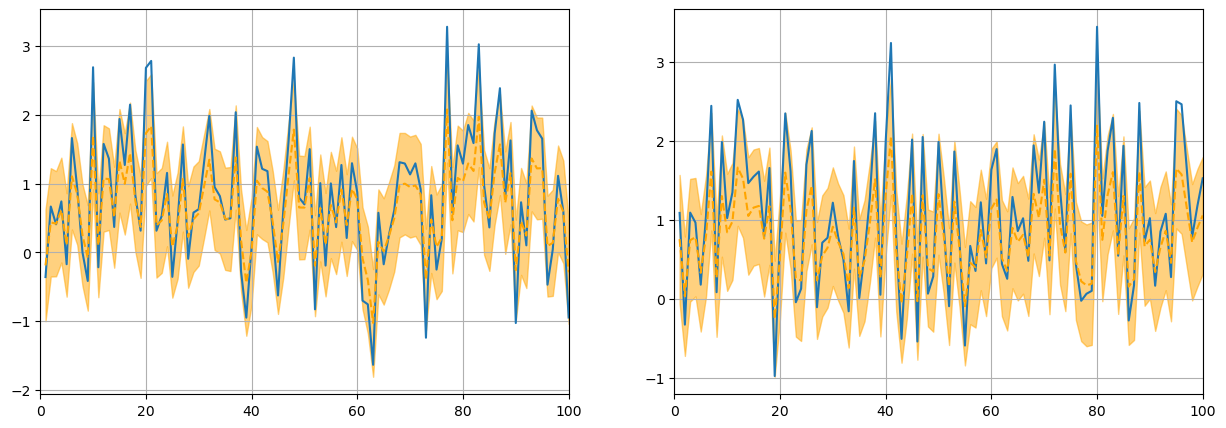

In [111]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(1:T, y[:,1])
ax[2].plot(1:T, y[:,2])
ax[1].fill_between(1:T, mx_ukf[1,:] .+ sqrt.(Vx_ukf[1,:]), mx_ukf[1,:] .- sqrt.(Vx_ukf[1,:]), color="orange", alpha=0.5)
ax[2].fill_between(1:T, mx_ukf[2,:] .+ sqrt.(Vx_ukf[2,:]), mx_ukf[2,:] .- sqrt.(Vx_ukf[2,:]), color="orange", alpha=0.5)
ax[1].plot(1:T, mx_ukf[1,:], linestyle="--", color="orange")
ax[2].plot(1:T, mx_ukf[2,:], linestyle="--", color="orange")
ax[1].grid(), ax[2].grid(), ax[1].set_xlim(0,T), ax[2].set_xlim(0,T);

In [112]:
MSE1 = sum(abs2.(y[:,1] - mx_ukf[1,:]))/T
MSE2 = sum(abs2.(y[:,2] - mx_ukf[2,:]))/T
10*log10(MSE1), 10*log10(MSE2)

(-7.0191818872710865, -6.417324011472924)

In [113]:
logp = sum([logpdf(MvNormal(m_ukf[k], collect(Hermitian(V_ukf[k]))), y[k,:]) for k=1:T])/T

-1.6480472962332526

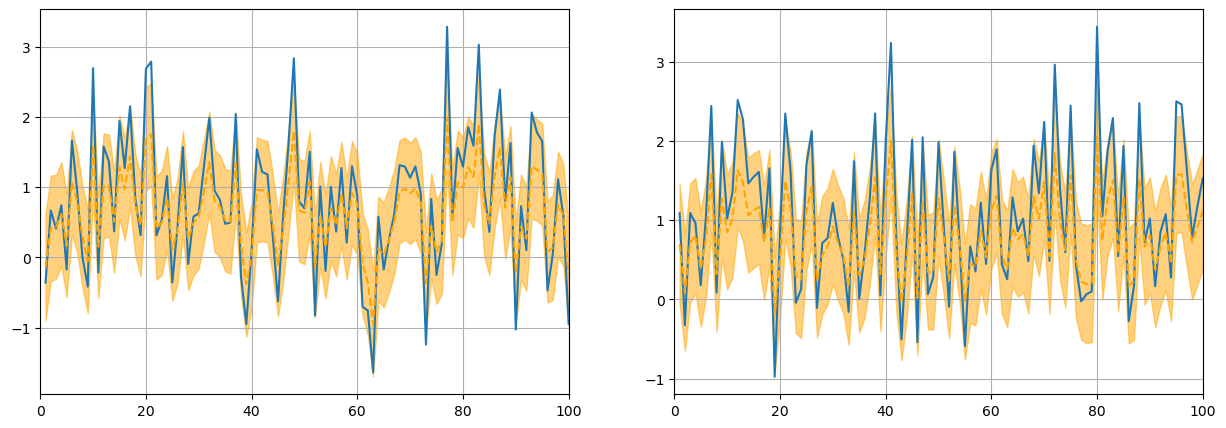

In [114]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(1:T, y[:,1])
ax[2].plot(1:T, y[:,2])
ax[1].fill_between(1:T, mx_pf[1,:] .+ sqrt.(Vx_pf[1,:]), mx_pf[1,:] .- sqrt.(Vx_pf[1,:]), color="orange", alpha=0.5)
ax[2].fill_between(1:T, mx_pf[2,:] .+ sqrt.(Vx_pf[2,:]), mx_pf[2,:] .- sqrt.(Vx_pf[2,:]), color="orange", alpha=0.5)
ax[1].plot(1:T, mx_pf[1,:], linestyle="--", color="orange")
ax[2].plot(1:T, mx_pf[2,:], linestyle="--", color="orange")
ax[1].grid(), ax[2].grid(), ax[1].set_xlim(0,T), ax[2].set_xlim(0,T);

In [115]:
MSE1 = sum(abs2.(y[:,1] - mx_pf[1,:]))/T
MSE2 = sum(abs2.(y[:,2] - mx_pf[2,:]))/T
10*log10(MSE1), 10*log10(MSE2)

(-6.539096485424692, -6.002522001993063)

In [116]:
logp = sum([logpdf(MvNormal(m_pf[k], collect(Hermitian(V_pf[k]))), y[k,:]) for k=1:T])/T

-1.657008539880757

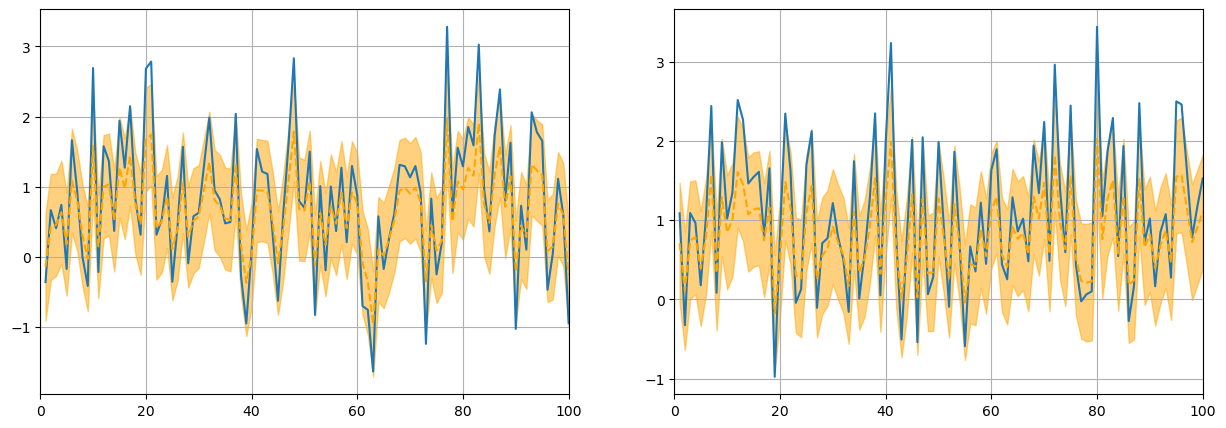

In [117]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(1:T, y[:,1])
ax[2].plot(1:T, y[:,2])
ax[1].fill_between(1:T, mx_xf[1,:] .+ sqrt.(Vx_xf[1,:]), mx_xf[1,:] .- sqrt.(Vx_xf[1,:]), color="orange", alpha=0.5)
ax[2].fill_between(1:T, mx_xf[2,:] .+ sqrt.(Vx_xf[2,:]), mx_xf[2,:] .- sqrt.(Vx_xf[2,:]), color="orange", alpha=0.5)
ax[1].plot(1:T, mx_xf[1,:], linestyle="--", color="orange")
ax[2].plot(1:T, mx_xf[2,:], linestyle="--", color="orange")
ax[1].grid(), ax[2].grid(), ax[1].set_xlim(0,T), ax[2].set_xlim(0,T);

In [118]:
MSE1 = sum(abs2.(y[:,1] - mx_xf[1,:]))/T
MSE2 = sum(abs2.(y[:,2] - mx_xf[2,:]))/T
10*log10(MSE1), 10*log10(MSE2)

(-6.497819058490478, -5.931094718173676)

In [119]:
logp = sum([logpdf(MvNormal(m_xf[k], collect(Hermitian(V_xf[k]))), y[k,:]) for k=1:T])/T

-1.66457884429066